In [8]:
#!/usr/bin/env python
"""
Demo for tomography test problem on a small scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Silvia Gazzola"
__affiliations__ = 'MIT and Tufts University, and University of Bath'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "mpasha@mit.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk;"

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import inv
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.utilities.phantoms import *
import pylops
from trips.test_problems.Tomography import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import CGLS
# from trips.solvers.golub_kahan_tikhonov import *
from trips.solvers.GMRES import GMRES

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem. Show how the forward operator can be accessed as a matrix (for relatively small problems).
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution


In [11]:
# Define an object of the class Tomogrpahy
Tomo = Tomography(CommitCrime = False)
# Specify the dimensions of the phantom and the number of angels that we call views
views = 30
nx = 32
ny = 32
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(testproblem, nx = nx, ny = ny)
# Step 2: Define the forward operator
A = Tomo.forward_Op(nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(b, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

settings
no crime


##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

In [12]:
# First we compute a naive solution
# x_naive = A.T@b.reshape((-1,1))
AA = A.todense()
x_naive = np.linalg.solve(AA.T@AA, AA.T@b_vec)

(-0.5, 1023.5, 1349.5, -0.5)

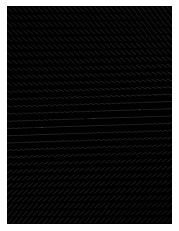

In [14]:
plt.imshow(AA)
plt.set_cmap('gray')
plt.axis('off')

(-0.5, 44.5, 29.5, -0.5)

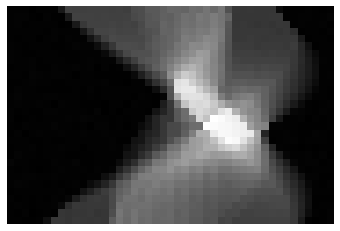

In [15]:
plt.imshow(b)
plt.set_cmap('gray')
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

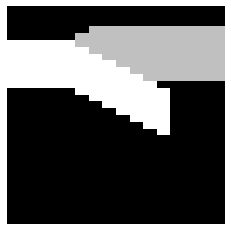

In [16]:
plt.imshow(x_true.reshape((nx, ny)))
plt.set_cmap('gray')
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

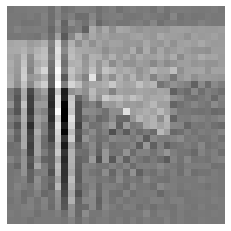

In [17]:
plt.imshow(x_naive.reshape((nx, ny)))
plt.set_cmap('gray')
plt.axis('off')

In [27]:
np.linalg.norm(x_naive - x_true)/np.linalg.norm(x_true)

1.0935410221610902

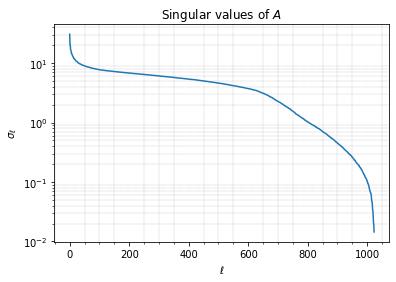

In [10]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

##### Plot some of the singular vectors

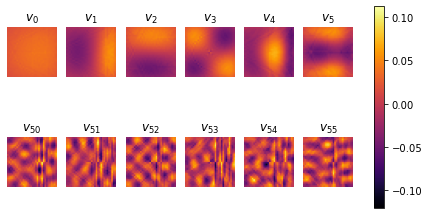

In [20]:
plot_singular_vectors_svd(Operator = A, size = nx, parameter = 'A')

##### 1.2. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 31.5, 31.5, -0.5)

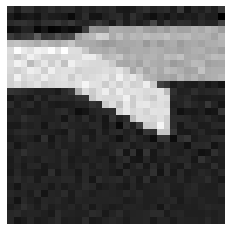

In [21]:
truncated_value = 600 # a value that can be changed to define a good regularization parameter
b_vec = b.reshape((-1,1))
(x_tsvd, truncation_value) = tSVD_sol(A.todense(), b_vec, regparam = 'dp', delta = delta)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

In [24]:
np.linalg.norm(x_tsvd - x_true)/np.linalg.norm(x_true)

0.12061112468624989

In [22]:
# Define a derivative operator as a regularization operator
from trips.utilities.operators import *
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=2, n_iter = 200, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 200/200 [00:12<00:00, 16.02it/s]


(-0.5, 31.5, 31.5, -0.5)

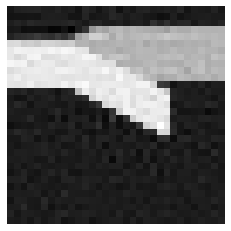

In [23]:
plt.imshow(x_gks.reshape((nx, ny)))
plt.axis('off')

In [26]:
np.linalg.norm(x_gks - x_true)/np.linalg.norm(x_true)

0.08471710437087025